# Napari-based parameters selection

Use Napari to interactively modify parameters for spot finding and visualize the results.

## Select DoG or LoG

Wewant to select the min and max size for DoG or LoG kernels, and compare the kernels to spots in a real FISH image.

In [1]:
import os
import time
import glob
import joblib
import warnings
from pathlib import Path

import numpy as np
import scipy.signal
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import filters

from tifffile import tifffile
import zarr
import dask.array as da
from dask_image.imread import imread
from dask import delayed
from skimage.io.collection import alphanumeric_key
import pycromanager
import napari
from napari.qt.threading import thread_worker
from magicgui import magicgui
# from matplotlib.colors import PowerNorm, LinearSegmentedColormap, Normalize

import localize_psf.rois as roi_fns
from localize_psf import fit
import localize_psf.fit_psf as psf
from localize_psf import localize
import localize_skewed
import image_post_processing as ipp
from image_post_processing import deskew

CUPY_AVAILABLE False


In [2]:
dir_load = Path('../../../from_server')
round = 1
channel = 2
tile = 0

viewer = napari.Viewer()
path_im = dir_load / 'round-{}_channel-{}_tile-{}.zarr'.format(round, channel, tile)
im = da.from_zarr(str(path_im))
# im = da.moveaxis(im, 1, 0)
print(im.shape)
img = im[:, 1000:1512, 512:1024].compute()
mini = img.min() # 0
maxi = img.max()
# mini = im.min().compute() # 0
# maxi = im.max().compute()
viewer.add_image(
    img, 
    contrast_limits=[mini, maxi], 
    name='ch_' + str(channel), 
    # colormap=color, 
    blending='additive',
    )

(512, 9833, 1584)


<Image layer 'ch_2' at 0x7fa28963f0d0>

In [6]:
# imgs_gauss = [filters.gaussian(x, sigma=1) for x in imgs]

(512, 512, 512)

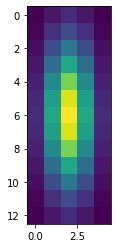

In [3]:
sigmas = [3., 1.]
drs = [1, 1]
kernel = localize.get_filter_kernel(sigmas, drs, sigma_cutoff=2)
plt.imshow(kernel)

In [48]:
# def get_gaussND(shape, sigmas):
#     """
#     Compute a N-dimensional gaussian kernel.

#     Parameters
#     ----------
#     shape : list(int)
#         Shape of the whole kernel ndarray.
#     sigmas : int of list(int)
#         Standard deviation, different for each dimension if a list is provided.
    
#     Returns
#     -------
#     kernel : ndarray
#         The N-dimensional gaussian kernel.
#     """
#     boundaries = [int((ss-1.)/2.) for ss in shape]
#     inputs = [np.expand_dims(np.arange(-x, x+1), axis=i) for i, x in enumerate(boundaries)]
#     if isinstance(sigmas, list):
#         sigmas = [np.expand_dims(np.full(shape[i] - 1, fill_value=x), axis=i) for i, x in enumerate(sigmas)]
#     kernel = np.exp(sum([-rk ** 2 / 2 / sig ** 2 for rk, sig in zip(inputs, sigmas)]))
#     kernel = kernel / np.sum(kernel)
#     return kernel

In [49]:
# kernel = get_gaussND(shape=[50, 50], sigmas=[3, 10])
# plt.imshow(kernel, cmap='magma')
# plt.colorbar()
# # y,x = np.ogrid[-m:m+1,-n:n+1]

In [4]:
kernel_skewed = localize_skewed.get_filter_kernel_skewed(sigmas=[10, 3, 3], dc=.115, theta=np.pi*30/180, dstage=.4, sigma_cutoff=2)
kernel_skewed.shape

(117, 699, 105)

In [5]:
viewer = napari.Viewer()

kernel = localize.get_filter_kernel(sigmas=[10, 3, 3], drs=[.115, .115, .115], sigma_cutoff=2)
viewer.add_image(kernel, name='kernel', colormap='green', blending='additive')

# kernel_skewed = deskew(kernel, theta=30, distance=1, pixel_size=1)
# viewer.add_image(kernel_skewed, name='kernel_skewed', colormap='red', blending='additive')
kernel_skewed = localize_skewed.get_filter_kernel_skewed(sigmas=[10, 3, 3], dc=.115, theta=np.pi*30/180, dstage=.4, sigma_cutoff=2)
kernel_deskewed = deskew(kernel_skewed, theta=30, distance=.4, pixel_size=.115)
# viewer.add_image(kernel_skewed, name='kernel_skewed', colormap='red', blending='additive')
viewer.add_image(kernel_deskewed, name='kernel_deskewed', colormap='red', blending='additive')


<Image layer 'kernel_deskewed' at 0x7fa2501b3580>

In [70]:
print(kernel.shape)
print(kernel_skewed.shape)


(41, 13, 13)
(11, 0, 13)


the `deskew` function outputs a rotated image, with within it a (de)skewed object that is trimmed at the border of the image.

### Napari parameters selection

In [7]:
viewer = napari.Viewer()